In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling

In [35]:
class SOM:
    def __init__(self, x, y, input_len, learning_rate=0.5, sigma=None, max_iter=1000):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma else max(x, y) / 2.0
        self.max_iter = max_iter
        self.weights = np.random.rand(x, y, input_len)
        self._xx, self._yy = np.meshgrid(np.arange(x), np.arange(y))

    def _neighborhood(self, winner, iteration):
        sigma = self.sigma * np.exp(-iteration / self.max_iter)
        d = (self._xx - winner[0]) ** 2 + (self._yy - winner[1]) ** 2
        return np.exp(-d / (2 * sigma ** 2))

    def _learning_rate(self, iteration):
        return self.learning_rate * np.exp(-iteration / self.max_iter)

    def winner(self, x):
        diff = self.weights - x
        dist = np.linalg.norm(diff, axis=2)
        return np.unravel_index(np.argmin(dist), (self.x, self.y))

    def train(self, data):
        for it in range(self.max_iter):
            idx = np.random.randint(0, data.shape[0])
            v = data[idx]
            win = self.winner(v)
            lr = self._learning_rate(it)
            nb = self._neighborhood(win, it)
            for i in range(self.x):
                for j in range(self.y):
                    self.weights[i, j] += lr * nb[i, j] * (v - self.weights[i, j])

    def map_vects(self, data):
        mapped = np.zeros((data.shape[0], 2), dtype=int)
        for i, v in enumerate(data):
            mapped[i] = self.winner(v)
        return mapped

In [36]:
def load_multispectral_image(filepath):
    img = io.imread(filepath)
    img = img.astype(np.float32)
    img /= img.max()
    return img

def reshape_image_to_vectors(img):
    h, w, bands = img.shape
    return img.reshape(-1, bands), h, w

def reconstruct_image_from_vectors(vectors, h, w, bands):
    return vectors.reshape(h, w, bands)

In [37]:
def compress_image_with_som(img, som):
    vectors, h, w = reshape_image_to_vectors(img)
    bmus = som.map_vects(vectors)
    compressed_vectors = np.zeros_like(vectors)
    for i, (bx, by) in enumerate(bmus):
        compressed_vectors[i] = som.weights[bx, by]
    return reconstruct_image_from_vectors(compressed_vectors, h, w, img.shape[2])

In [38]:
def compute_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

In [39]:
band_img_files = [
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B02_(Raw).tiff",
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B03_(Raw).tiff",
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B04_(Raw).tiff",
    "C:/Users/Pushp Raj Choudhary/Downloads/Browser_images_3/2024-11-01-00_00_2025-05-01-23_59_Sentinel-2_L2A_B08_(Raw).tiff",
]

ref_band_path = band_img_files[0]
with rasterio.open(ref_band_path) as ref:
    ref_meta = ref.meta.copy()
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_shape = (ref.height, ref.width)

bands_data = []

for band_file in band_img_files:
    with rasterio.open(band_file) as src:
        data = np.zeros(ref_shape, dtype=src.meta['dtype'])
        rasterio.warp.reproject(
            source=src.read(1),
            destination=data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest 
        )
        bands_data.append(data)

bands_array = np.stack(bands_data, axis=0)

ref_meta.update(count=len(band_img_files))

output_path = 'C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif'
with rasterio.open(output_path, 'w', **ref_meta) as dst:
    for i in range(len(band_img_files)):
        dst.write(bands_array[i], i + 1)  

print(f"Multi-band TIFF saved to {output_path}")

Multi-band TIFF saved to C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif


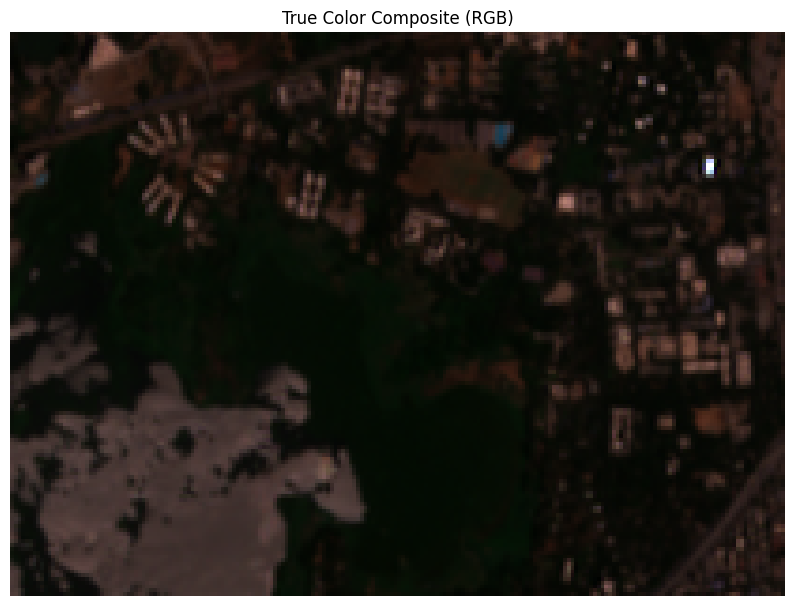

In [40]:
with rasterio.open('C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif') as src:
    red = src.read(3).astype(float)  # B04
    green = src.read(2).astype(float)  # B03
    blue = src.read(1).astype(float)  # B02

def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

rgb = np.stack([normalize(red), normalize(green), normalize(blue)], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("True Color Composite (RGB)")
plt.axis('off')
plt.show()

In [42]:
def plot_som_grid(som):
    codebook = som.weights
    x, y, bands = codebook.shape
    grid_img = np.zeros((x, y, 3))
    for i in range(x):
        for j in range(y):
            grid_img[i, j, :bands] = codebook[i, j, :3]
    plt.figure(figsize=(4, 4))
    plt.imshow(grid_img)
    plt.title("SOM Codebook (Grid)")
    plt.axis('off')
    plt.show()

def get_compressed_position_image(img, som):
    vectors, h, w = reshape_image_to_vectors(img)
    bmus = som.map_vects(vectors)
    bmu_labels = bmus[:,0] * som.y + bmus[:,1]
    return bmu_labels.reshape(h, w)

Training SOM with grid size 4x4...
MSE for SOM 4x4: 0.00082


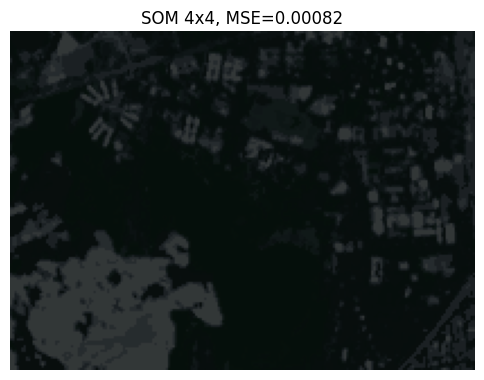

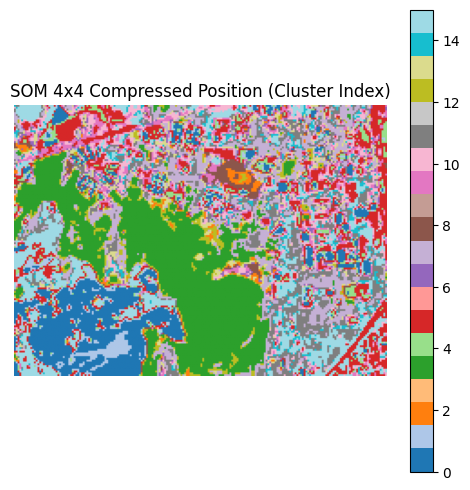

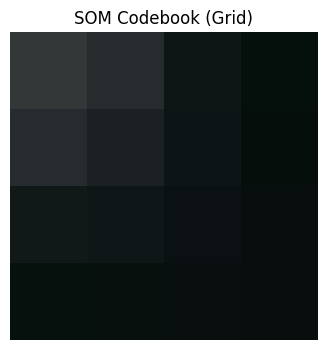

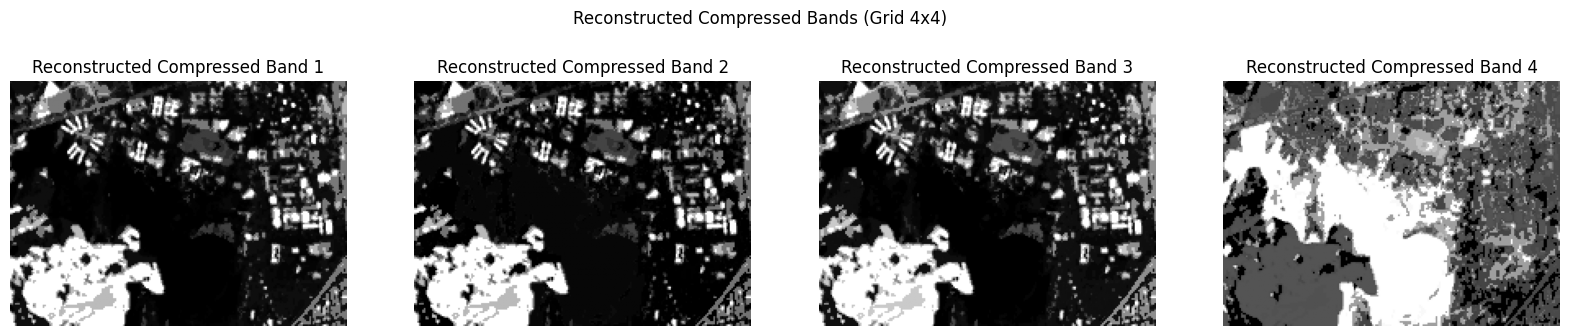

Training SOM with grid size 8x8...
MSE for SOM 8x8: 0.00064


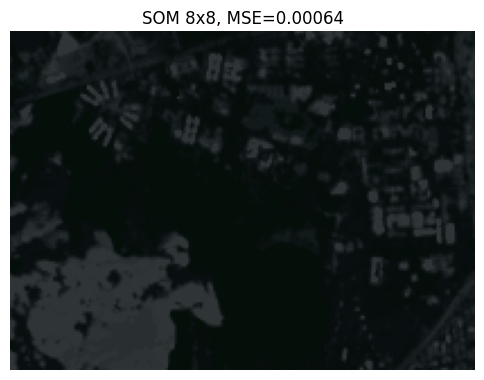

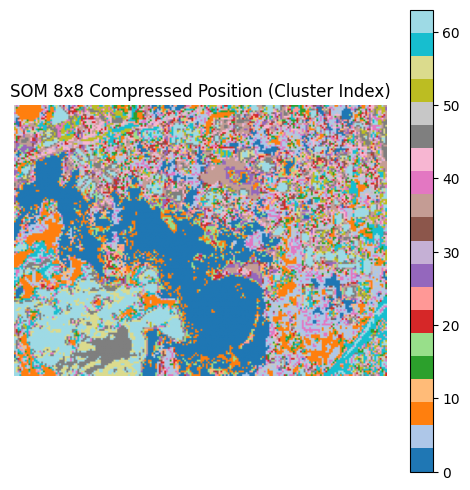

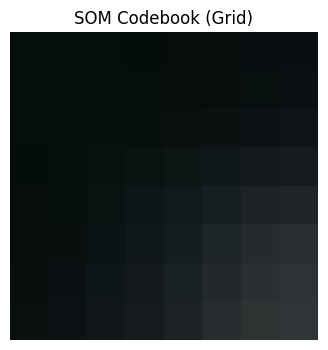

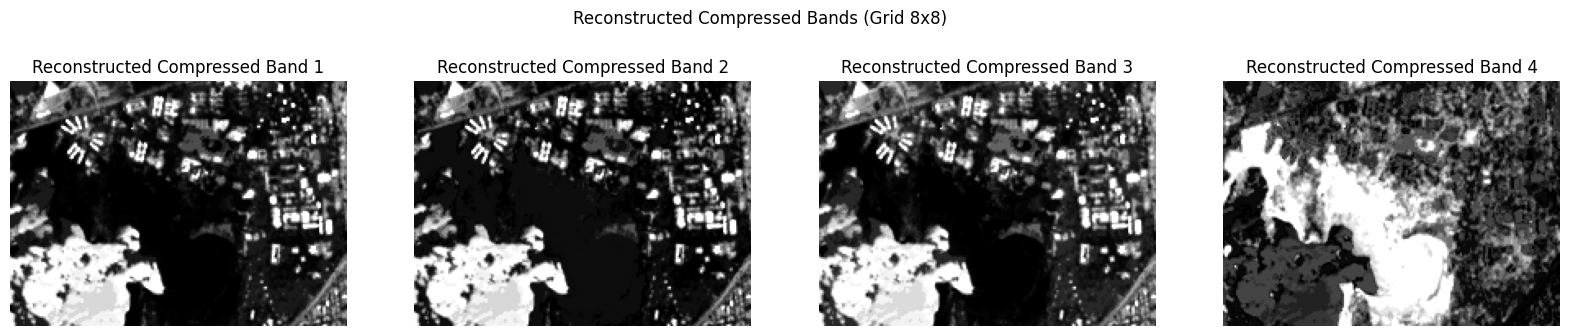

Training SOM with grid size 12x12...
MSE for SOM 12x12: 0.00061


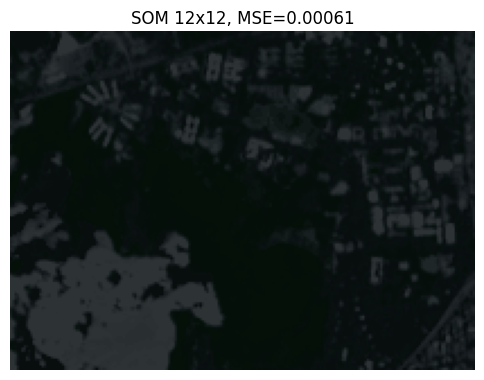

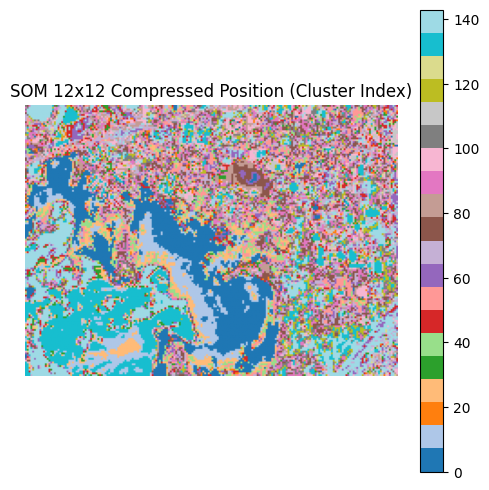

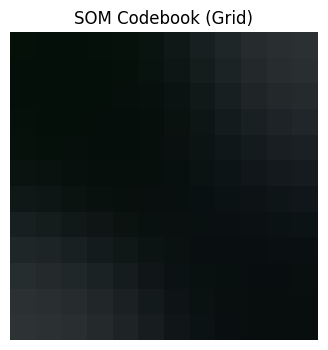

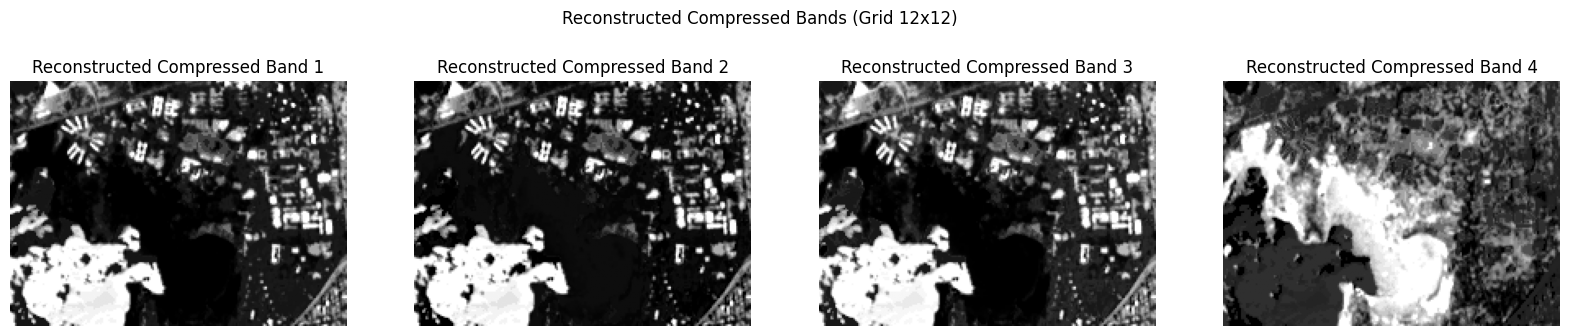

Training SOM with grid size 16x16...
MSE for SOM 16x16: 0.00041


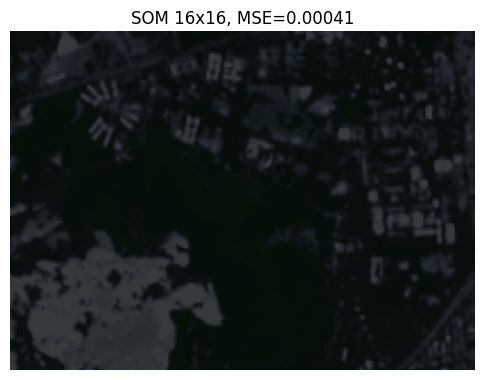

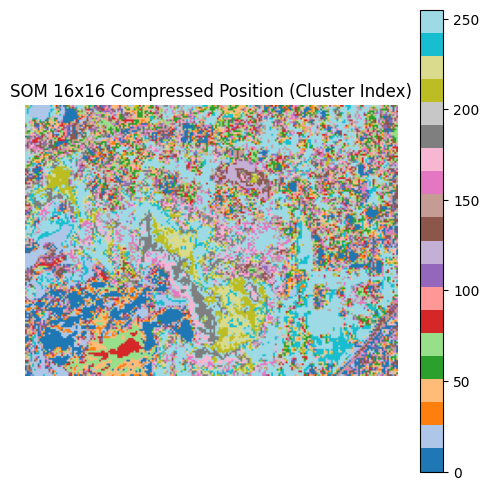

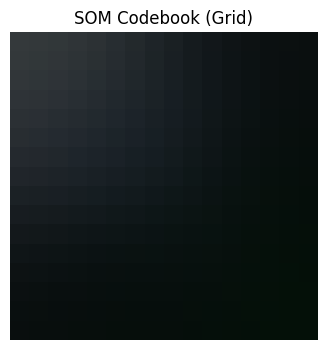

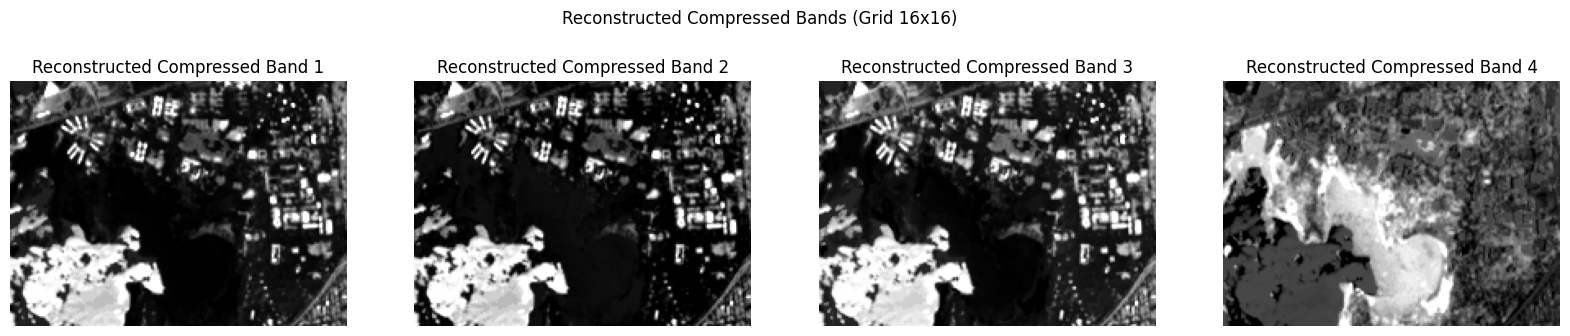

Training SOM with grid size 20x20...
MSE for SOM 20x20: 0.00058


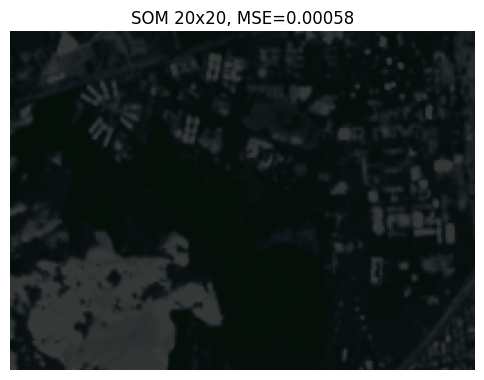

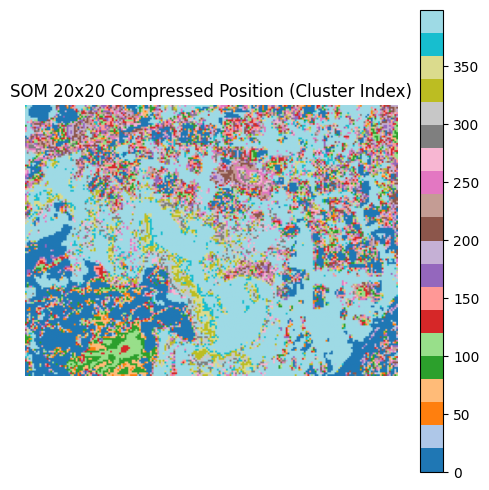

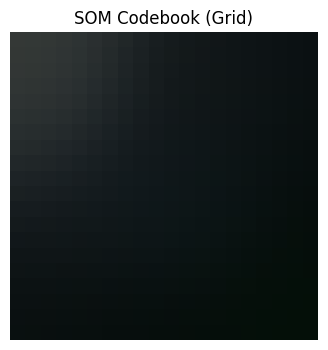

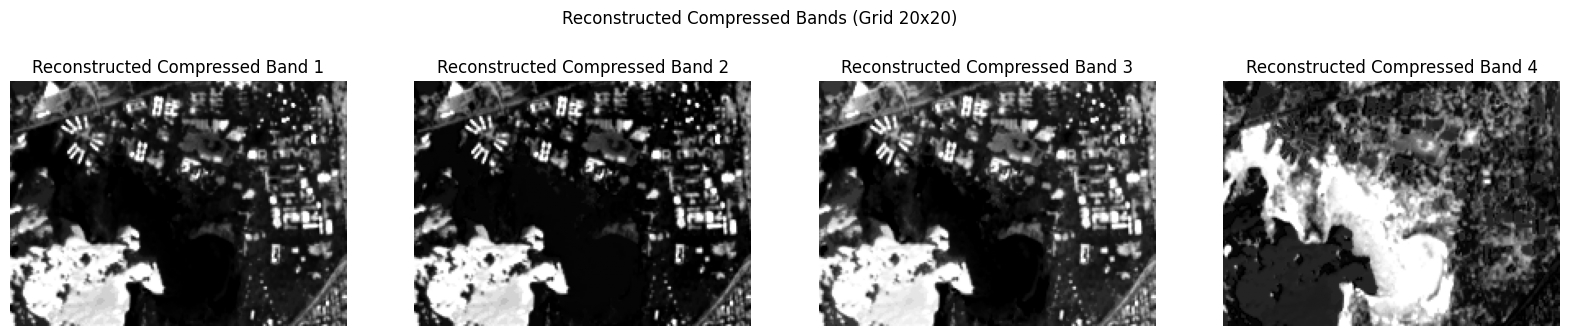

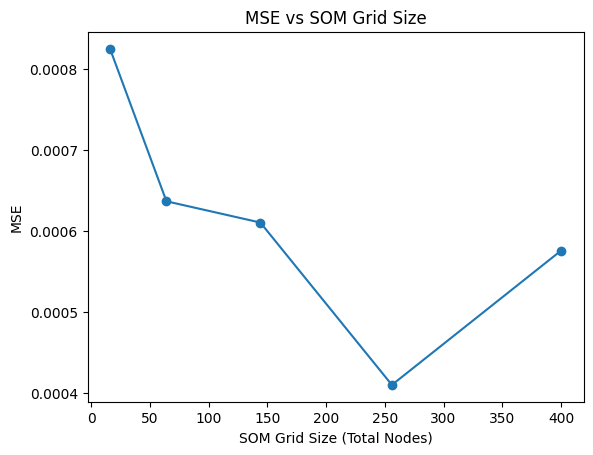

In [43]:
image_path = "C:/Users/Pushp Raj Choudhary/Downloads/combined_multiband_gnr.tif"
img = load_multispectral_image(image_path)

if img.shape[2] >= 3:
    img_vis = img[:, :,:3]
else:
    img_vis = img

grid_sizes = [(4,4), (8,8), (12,12), (16,16), (20,20)]
mses = []

for gx, gy in grid_sizes:
    print(f"Training SOM with grid size {gx}x{gy}...")
    som = SOM(gx, gy, img.shape[2], learning_rate=0.5, max_iter=1000)
    vectors, h, w = img.reshape(-1, img.shape[2]), img.shape[0], img.shape[1]
    som.train(vectors)
    compressed_img = compress_image_with_som(img, som)
    mse = compute_mse(img, compressed_img)
    mses.append(mse)
    print(f"MSE for SOM {gx}x{gy}: {mse:.5f}")

    plt.figure(figsize=(6, 6))
    plt.imshow(compressed_img[:, :, :3])
    plt.title(f'SOM {gx}x{gy}, MSE={mse:.5f}')
    plt.axis('off')
    plt.show()

    bmu_labels_img = get_compressed_position_image(img, som)
    plt.figure(figsize=(6, 6))
    plt.imshow(bmu_labels_img, cmap='tab20')
    plt.title(f'SOM {gx}x{gy} Compressed Position (Cluster Index)')
    plt.axis('off')
    plt.colorbar()
    plt.show()

    plot_som_grid(som)

    fig, axes = plt.subplots(1, img.shape[2], figsize=(5*img.shape[2], 4))
    for b in range(img.shape[2]):
        axes[b].imshow(compressed_img[:, :, b], cmap='gray')
        axes[b].set_title(f'Reconstructed Compressed Band {b+1}')
        axes[b].axis('off')
    plt.suptitle(f"Reconstructed Compressed Bands (Grid {gx}x{gy})")
    plt.show()

plt.figure()
plt.plot([gx*gy for gx,gy in grid_sizes], mses, marker='o')
plt.xlabel('SOM Grid Size (Total Nodes)')
plt.ylabel('MSE')
plt.title('MSE vs SOM Grid Size')
plt.show()

#### Functions for displaying images in GUI

In [49]:
def get_compressed_position_image(img, som):
    vectors, h, w = img.reshape(-1, img.shape[2]), img.shape[0], img.shape[1]
    bmus = som.map_vects(vectors)
    bmu_labels = bmus[:,0] * som.y + bmus[:,1]
    return bmu_labels.reshape(h, w)

def get_som_codebook_image(som, size=128):
    codebook = som.weights
    x, y, bands = codebook.shape
    grid_img = np.zeros((x, y, 3))
    for i in range(x):
        for j in range(y):
            grid_img[i, j, :bands] = codebook[i, j, :3]
    grid_img_disp = Image.fromarray((grid_img * 255).astype(np.uint8)).resize((size, size), Image.NEAREST)
    return grid_img_disp

def get_rgb(img, size=128):
    if img.shape[2] >= 3:
        rgb = img[:, :, :3]
    else:
        rgb = np.repeat(img[:, :, [0]], 3, axis=2)
    rgb = (rgb * 255).astype(np.uint8)
    return Image.fromarray(rgb).resize((size, size), Image.NEAREST)

#### GUI

In [52]:
class SOMGUI:
    def __init__(self, master):
        self.master = master
        master.title("SOM Multispectral Image Clustering")
        self.img = None
        self.compressed_img = None
        self.current_band = 1

        self.load_btn = tk.Button(master, text="Load Image", command=self.load_image)
        self.load_btn.grid(row=0, column=0, columnspan=4, sticky="ew")

        self.grid_label = tk.Label(master, text="Grid Size (4, 8, 12, 16, 20):")
        self.grid_label.grid(row=1, column=0)
        self.grid_size_entry = tk.Entry(master)
        self.grid_size_entry.grid(row=1, column=1)
        self.grid_size_entry.insert(0, "8")

        self.band_slider = tk.Scale(master, from_=1, to=1, orient=tk.HORIZONTAL, label="Band", command=self.update_band)
        self.band_slider.grid(row=1, column=2, columnspan=2, sticky="ew")

        self.run_btn = tk.Button(master, text="Run SOM", command=self.run_som)
        self.run_btn.grid(row=2, column=0, columnspan=4, sticky="ew")

        # Row 1: RGB, Cluster, Reconstructed, SOM Grid
        self.label_rgb_orig = tk.Label(master, text="", compound='top')
        self.label_rgb_orig.grid(row=3, column=0)
        self.label_bmu_img = tk.Label(master, text="", compound='top')
        self.label_bmu_img.grid(row=3, column=1)
        self.label_rgb_comp = tk.Label(master, text="", compound='top')
        self.label_rgb_comp.grid(row=3, column=2)
        self.label_grid_img = tk.Label(master, text="", compound='top')
        self.label_grid_img.grid(row=3, column=3)

        # Row 2: Band-wise
        self.label_band_orig = tk.Label(master, text="", compound='top')
        self.label_band_orig.grid(row=4, column=0, columnspan=2)
        self.label_band_comp = tk.Label(master, text="", compound='top')
        self.label_band_comp.grid(row=4, column=2, columnspan=2)

        self.mse_label = tk.Label(master, text="")
        self.mse_label.grid(row=5, column=0, columnspan=4)

        self.tk_img_band_orig = None
        self.tk_img_band_comp = None
        self.tk_img_rgb_orig = None
        self.tk_img_rgb_comp = None
        self.tk_img_bmu = None
        self.tk_img_grid = None

    def load_image(self):
        path = filedialog.askopenfilename()
        if path:
            self.img = load_multispectral_image(path)
            self.compressed_img = None
            self.band_slider.config(to=self.img.shape[2])
            self.current_band = 1
            self.band_slider.set(1)
            self.display_images()

    def run_som(self):
        if self.img is None:
            return
        grid_size = int(self.grid_size_entry.get())
        som = SOM(grid_size, grid_size, self.img.shape[2], learning_rate=0.5, max_iter=1000)
        vectors, h, w = self.img.reshape(-1, self.img.shape[2]), self.img.shape[0], self.img.shape[1]
        som.train(vectors)
        self.compressed_img = compress_image_with_som(self.img, som)
        mse = compute_mse(self.img, self.compressed_img)

        # Compressed position cluster image
        bmu_labels_img = get_compressed_position_image(self.img, som)
        bmu_img = Image.fromarray(((bmu_labels_img / bmu_labels_img.max()) * 255).astype(np.uint8))
        bmu_img = bmu_img.resize((128, 128), Image.NEAREST)
        self.tk_img_bmu = ImageTk.PhotoImage(bmu_img)
        self.label_bmu_img.config(image=self.tk_img_bmu, text='Compressed Position (Cluster Index)', compound='top')

        # SOM grid/codebook
        grid_img_disp = get_som_codebook_image(som, size=128)
        self.tk_img_grid = ImageTk.PhotoImage(grid_img_disp)
        self.label_grid_img.config(image=self.tk_img_grid, text="SOM Grid", compound='top')

        self.display_images()
        self.mse_label.config(text=f"MSE: {mse:.5f}")

    def update_band(self, val):
        self.current_band = int(val)
        self.display_images()

    def display_images(self):
        if self.img is not None:
            band = self.current_band - 1
            # Band-wise
            orig_band = Image.fromarray((self.img[:,:,band] * 255).astype(np.uint8)).resize((128, 128), Image.NEAREST)
            self.tk_img_band_orig = ImageTk.PhotoImage(orig_band)
            self.label_band_orig.config(image=self.tk_img_band_orig, text=f"Original Band {self.current_band}", compound='top')

            if self.compressed_img is not None:
                comp_band = Image.fromarray((self.compressed_img[:,:,band] * 255).astype(np.uint8)).resize((128, 128), Image.NEAREST)
                self.tk_img_band_comp = ImageTk.PhotoImage(comp_band)
                self.label_band_comp.config(image=self.tk_img_band_comp, text=f"Reconstructed Compressed Band {self.current_band}", compound='top')

            # RGB row
            rgb_img = get_rgb(self.img, size=128)
            self.tk_img_rgb_orig = ImageTk.PhotoImage(rgb_img)
            self.label_rgb_orig.config(image=self.tk_img_rgb_orig, text="Original RGB", compound='top')
            if self.compressed_img is not None:
                comp_rgb = get_rgb(self.compressed_img, size=128)
                self.tk_img_rgb_comp = ImageTk.PhotoImage(comp_rgb)
                self.label_rgb_comp.config(image=self.tk_img_rgb_comp, text="Reconstructed Compressed RGB", compound='top')

if __name__ == "__main__":
    root = tk.Tk()
    app = SOMGUI(root)
    root.mainloop()
